# Derive spectral similarities using 'classical' measures (codine, modified cosine)

The code in this notebook is to derive an array of all-vs-all spectral similarity scores for the uniqueInchikey subset (about 11,000 spectra). 

### Import libraries, folder names, and Spec2Vec functions

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

# Import and filter MS-MS data from MGF file (positive ionization mode)

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
**1. Discard spectra with too few peaks.**  
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

**2. Filter out noise.**  
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  

**3. But keep enough information.**  
Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [ ]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

In [9]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


### Inspect data

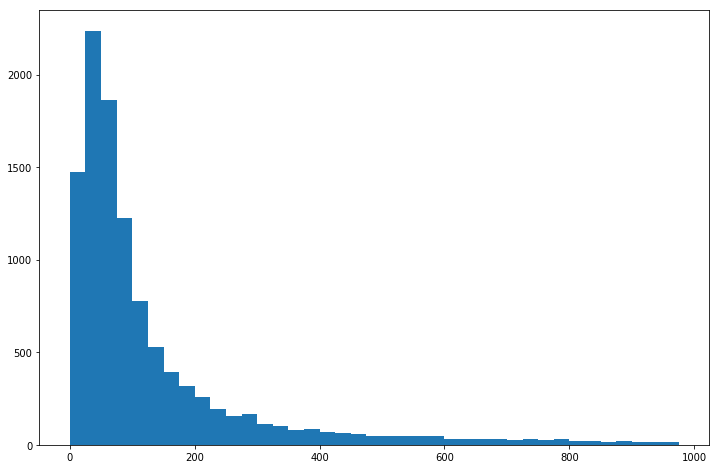

In [10]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,1000,25))

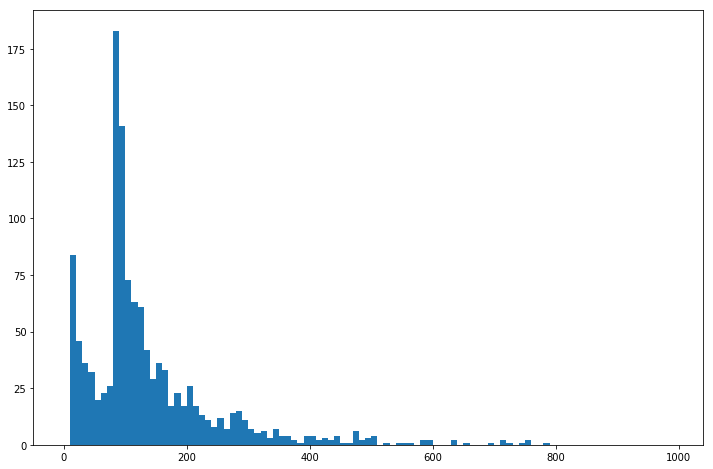

In [11]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)
    
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 700)], np.arange(0,1000,10))

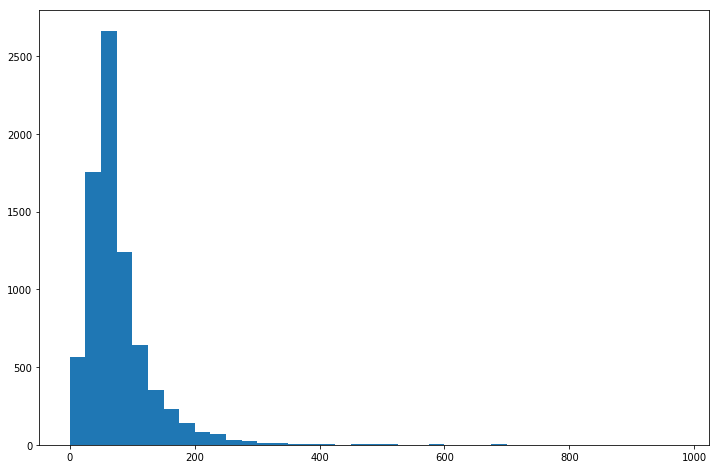

In [25]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)
    
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 300)], np.arange(0,1000,25))

---
# Calculate cosine scores for all-vs all spectra

The cosine score here has two key parameters: tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the cosine score by matching peaks of two spectra. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [12]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_cosine_200217_tol0005.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [14]:
# show number of matched peaks:
cosine_matches_greedy[:10,:10]

array([[25.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  1.,  1.],
       [ 1., 15.,  2.,  3.,  1.,  1.,  1.,  4.,  1.,  2.],
       [ 1.,  2., 17.,  3.,  2.,  2.,  1.,  2.,  1.,  0.],
       [ 2.,  3.,  3., 21.,  2.,  3.,  1.,  3.,  1.,  3.],
       [ 3.,  1.,  2.,  2., 17.,  3.,  1.,  1.,  1.,  1.],
       [ 3.,  1.,  2.,  3.,  3., 18.,  1.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  1.,  1., 10.,  2.,  2.,  1.],
       [ 1.,  4.,  2.,  3.,  1.,  1.,  2., 13.,  3.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  3., 18.,  1.],
       [ 1.,  2.,  0.,  3.,  1.,  1.,  1.,  2.,  1., 16.]])

---
# Calculate modified cosine scores for all-vs all spectra

Modified cosine score is -among others- used by [GNPS](https://ccms-ucsd.github.io/GNPSDocumentation/massspecbackground/networkingtheory/). It's key parameters are tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the modified cosine score. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [12]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_modcos_200217_tol0005.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [14]:
# show number of matched peaks:
modcos_matches_greedy[:10,:10]

array([[25.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  1.,  1.],
       [ 1., 15.,  2.,  3.,  1.,  1.,  1.,  4.,  1.,  2.],
       [ 1.,  2., 17.,  3.,  2.,  2.,  1.,  2.,  1.,  0.],
       [ 2.,  3.,  3., 21.,  2.,  3.,  1.,  3.,  1.,  3.],
       [ 3.,  1.,  2.,  2., 17.,  3.,  1.,  1.,  1.,  1.],
       [ 3.,  1.,  2.,  3.,  3., 18.,  1.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  1.,  1., 10.,  2.,  2.,  1.],
       [ 1.,  4.,  2.,  3.,  1.,  1.,  2., 13.,  3.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  3., 18.,  1.],
       [ 1.,  2.,  0.,  3.,  1.,  1.,  1.,  2.,  1., 16.]])

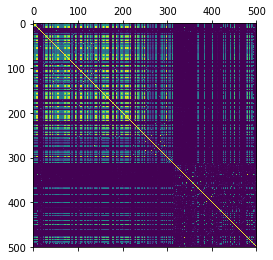

In [39]:
plt.matshow(modcos_sim_greedy[:500,:500])

---
# Compare to reference scores based on molecular fingerprints

In [3]:
from plotting_functions import plot_precentile

In [ ]:
A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A = np.delete(A.reshape(length**2), remove_diagonal)

#B = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
#B = np.delete(B.reshape(length**2), remove_diagonal)

In [ ]:
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(A, B, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_2048_dice.npy'), 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

---
# Compare to scores with lower tolerance 
[GNPS suggests](https://ccms-ucsd.github.io/GNPSDocumentation/networking/) either $\pm 0.5 Da$ for low resolution MS, or $\pm 0.02 Da$ for high resolution MS.

## Calculate cosine scores for all-vs all spectra

The cosine score here has two key parameters: tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the cosine score by matching peaks of two spectra. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [12]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_cosine_200217_tol002.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.02,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [14]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_cosine_200217_tol05.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.5,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

array([[25.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  1.,  1.],
       [ 1., 15.,  2.,  3.,  1.,  1.,  1.,  4.,  1.,  2.],
       [ 1.,  2., 17.,  3.,  2.,  2.,  1.,  2.,  1.,  0.],
       [ 2.,  3.,  3., 21.,  2.,  3.,  1.,  3.,  1.,  3.],
       [ 3.,  1.,  2.,  2., 17.,  3.,  1.,  1.,  1.,  1.],
       [ 3.,  1.,  2.,  3.,  3., 18.,  1.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  1.,  1., 10.,  2.,  2.,  1.],
       [ 1.,  4.,  2.,  3.,  1.,  1.,  2., 13.,  3.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  3., 18.,  1.],
       [ 1.,  2.,  0.,  3.,  1.,  1.,  1.,  2.,  1., 16.]])

## Calculate modified cosine scores for all-vs all spectra

Modified cosine score is -among others- used by [GNPS](https://ccms-ucsd.github.io/GNPSDocumentation/massspecbackground/networkingtheory/). It's key parameters are tolerance (tol) and minimum number of matching peaks (min_match).

Spec2Vec includes two ways to compute the modified cosine score. The Hungarian algorithm can be used which is more accurate but much slower. Here, for this large dataset we used a greddy implementation instead.

In [12]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_modcos_200217_tol002.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.02,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [14]:
filename = PATH_COMPUTED + 'Similarities_uniqueInchikey_modcos_200217_tol05.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.5,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

array([[25.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  1.,  1.],
       [ 1., 15.,  2.,  3.,  1.,  1.,  1.,  4.,  1.,  2.],
       [ 1.,  2., 17.,  3.,  2.,  2.,  1.,  2.,  1.,  0.],
       [ 2.,  3.,  3., 21.,  2.,  3.,  1.,  3.,  1.,  3.],
       [ 3.,  1.,  2.,  2., 17.,  3.,  1.,  1.,  1.,  1.],
       [ 3.,  1.,  2.,  3.,  3., 18.,  1.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  1.,  1., 10.,  2.,  2.,  1.],
       [ 1.,  4.,  2.,  3.,  1.,  1.,  2., 13.,  3.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  3., 18.,  1.],
       [ 1.,  2.,  0.,  3.,  1.,  1.,  1.,  2.,  1., 16.]])